In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import spikeinterface.core as sc
import spikeinterface.extractors as se

n_s_per_min = 60
n_ms_per_s = 1000
figure_output_folder = 'figure/lateral'
os.makedirs(figure_output_folder, exist_ok=True)    

In [2]:
curation_multi = {
    ('L11_9', 5.0):{
        'region1': {
            (0, (0.5, 1)): [(2, 0), (6, 0), (7, 1)],
            (1, (7, 7.5)): [(1, 1), (5, 1), (6, 0), (8, 2)],
            (2, (5.1, 5.6)): [(4, 1), (5, 0), (7, 1), (8, 1)],
            (4, (0.75, 1.25)): [(1, 0), (4, 0), (6, 1), (7, 0), (8, 2), (9, 0)],
        },
        'region2': {
            (0, (6, 6.5)): [(3, 1), (5, 1)],
            (4, (6, 6.5)): [(5, 0)],
        },
    },
    ('L17_7', 5.0):{
        'region1': {
            (0, (1.5, 2)): [(6, 0), (8, 0)],
            (1, (0.1, 0.6)): [(1, 0), (3, 0)],
        },
    },
}
curation_single = {
    ('L14_5', 5.0): {
        (2, (2, 2.5)): [(3, 1)],
    }
}

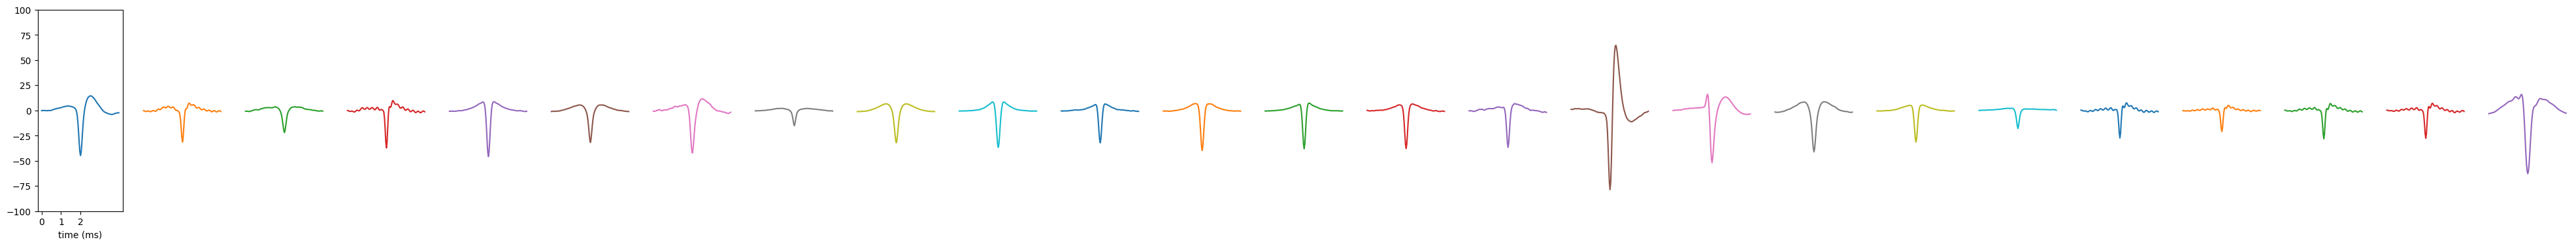

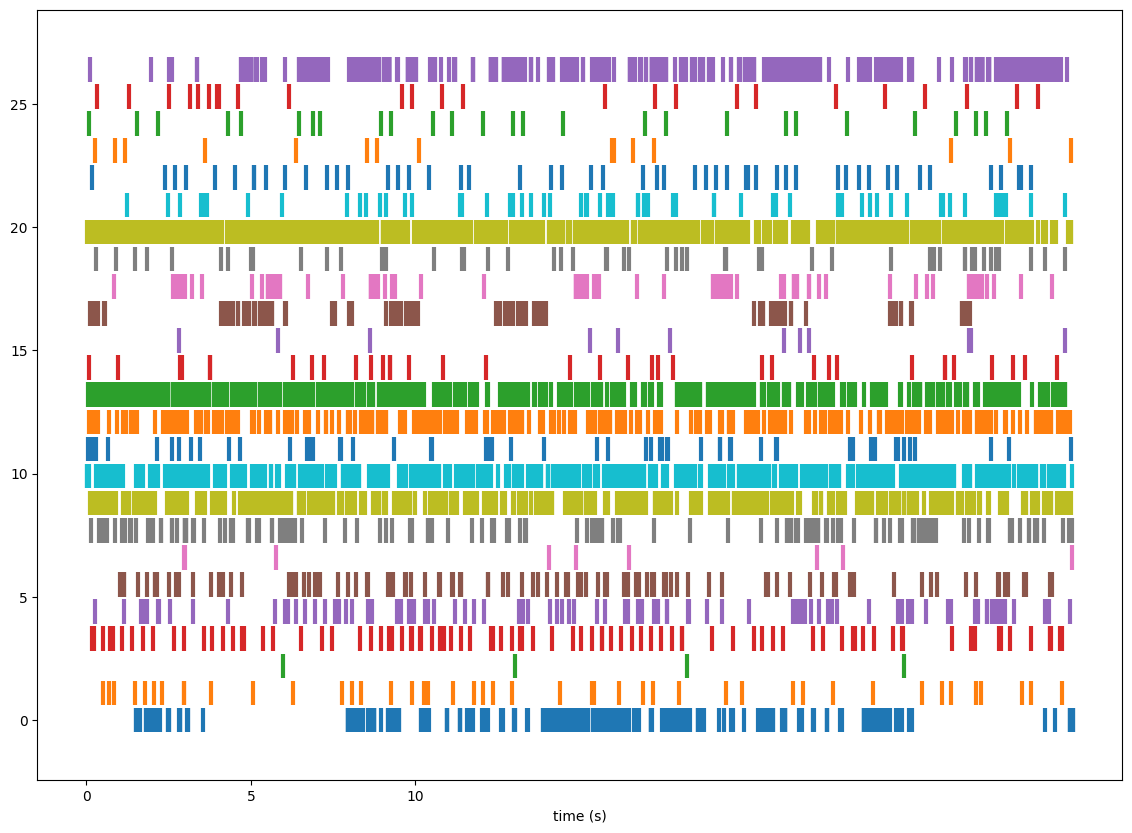

In [3]:
templates, events = [], []
for (subject, threshold), subject_curation in curation_multi.items():
    for region, region_curation in subject_curation.items():
        for (shank, (t_start_min, t_end_min)), shank_units in region_curation.items():
            for (unit_id, segment) in shank_units:
                sorting = se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/{region}/sorting{threshold}/sorter_output/segment{segment}_firings.npz')
                waveform_extractor = sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/{region}/waveform{threshold}/segment{segment}')

                n_frames_per_ms = sorting.sampling_frequency / n_ms_per_s
                extremum_channel = sc.get_template_extremum_channel(waveform_extractor, peak_sign='neg')[unit_id]
                extremum_channel = np.where(waveform_extractor.channel_ids == extremum_channel)[0].item()
                template = waveform_extractor.get_template(unit_id=unit_id)[:, extremum_channel]     
                spike_train = sorting.get_unit_spike_train(unit_id=unit_id)  
                spike_train = spike_train[(spike_train >= t_start_min * n_s_per_min * sorting.sampling_frequency) & (spike_train <= t_end_min * n_s_per_min * sorting.sampling_frequency)]
                spike_train = spike_train - t_start_min * n_s_per_min * sorting.sampling_frequency

                templates.append(template)
                events.append(spike_train)
                
for (subject, threshold), subject_curation in curation_single.items():
    for (shank, (t_start_min, t_end_min)), shank_units in subject_curation.items():
        for (unit_id, segment) in shank_units:
            sorting = se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz')
            waveform_extractor = sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}')

            n_frames_per_ms = sorting.sampling_frequency / n_ms_per_s
            extremum_channel = sc.get_template_extremum_channel(waveform_extractor, peak_sign='neg')[unit_id]
            extremum_channel = np.where(waveform_extractor.channel_ids == extremum_channel)[0].item()
            template = waveform_extractor.get_template(unit_id=unit_id)[:, extremum_channel]     
            spike_train = sorting.get_unit_spike_train(unit_id=unit_id)  
            spike_train = spike_train[(spike_train > t_start_min * n_s_per_min * sorting.sampling_frequency) & (spike_train <= t_end_min * n_s_per_min * sorting.sampling_frequency)]
            spike_train = spike_train - t_start_min * n_s_per_min * sorting.sampling_frequency

            templates.append(template)
            events.append(spike_train)

plt.figure(figsize=(len(templates)*2, 4))
for plot_index, template in enumerate(templates):
    ax = plt.subplot(1, len(templates), plot_index + 1)
    ax.plot(template, color=plt.cm.tab10(plot_index%10))
    if plot_index != 0: ax.set_axis_off()
    ax.set_xticks([0, n_frames_per_ms, n_frames_per_ms*2], [0, 1, 2])
    ax.set_xlabel('time (ms)')
    ax.set_ylim(-100, 100)
plt.savefig(f'{figure_output_folder}/templates.pdf')
plt.show()
plt.close()

plt.figure(figsize=(14, 10))
plt.eventplot(events, colors=[plt.cm.tab10(i%10) for i in range(len(events))], linewidths=3, lineoffsets=1.1)
plt.xticks([0, sorting.sampling_frequency * 5, sorting.sampling_frequency * 10], [0, 5, 10])
plt.xlabel('time (s)')
plt.savefig(f'{figure_output_folder}/raster.pdf')
plt.show()
plt.close()